# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>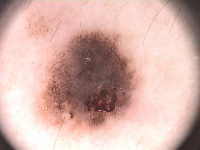</td><td>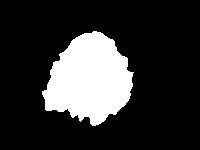</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
import numpy as np
import torch

def seed_init(SEED = 1500):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

seed_init()

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/drive/My Drive/Colab Notebooks/Segmentation/data/PH2Dataset/'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
Y_ = [resize(y, size, mode='constant', anti_aliasing=False) for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
Y_ = np.array(Y_, np.float32)
print(f'Loaded {len(X)} images')

Loaded 199 images


In [5]:
len(lesions)

199

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

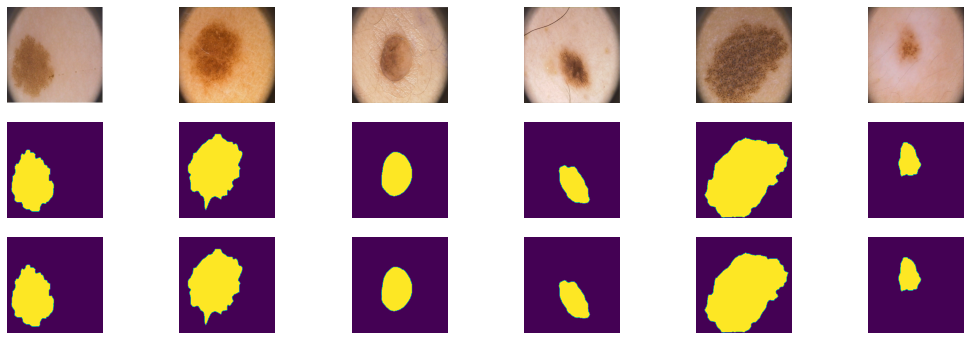

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(Y_[i])

plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 49


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
import copy
def save_weights(net, name):
    net_weights = copy.deepcopy(net.state_dict())
    torch.save(net_weights, name)
    !mv '/content/{name}' '/content/drive/My Drive/Colab Notebooks/Segmentation/weights'

In [0]:
def load_weights(*nets, paths):
    for net, path in zip(nets, paths):
        net.load_state_dict(torch.load(path))

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

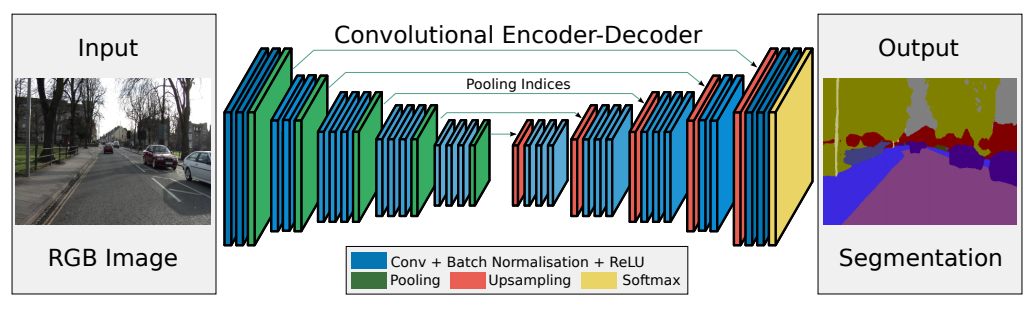

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from torchsummary import summary

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,8)

In [0]:
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.35),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.45),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode="bilinear") # 16 -> 32 
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.35),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.upsample1 =  nn.Upsample(scale_factor=2, mode="bilinear")# 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 =  nn.Upsample(scale_factor=2, mode="bilinear") # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.upsample3 =  nn.Upsample(scale_factor=2, mode="bilinear") # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [17]:
summary(SegNet().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded   

## функция лосса [1 балл]


Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_pred, y_real, reduce=True):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    y_pred = torch.sigmoid(y_pred)
    preout = y_pred.sub(y_real.mul(y_pred))
    out = preout.add((1 + (-y_pred).exp()).log())
    return out.mean() if reduce else out 

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def eval_epoch(model, val_loader, criterion, metric, threshold):
    running_loss = .0
    running_score = .0
    processed_size = len(val_loader)
    
    model = model.to(device)
    model.eval()
    for inputs, real_masks in val_loader:
        inputs = inputs.to(device)
        real_masks = real_masks.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, real_masks)
            pred_masks = torch.sigmoid(outputs) > threshold
        
        running_score += metric(pred_masks, real_masks).mean().item()
        running_loss += loss.item()
            
        
    val_loss = running_loss / processed_size
    val_score = running_score / processed_size
    return val_loss, val_score

In [0]:
def fit_epoch(model, train_loader, criterion, metric, op, threshold):
    running_loss = .0
    running_score = .0
    processed_data = len(train_loader)
    
    model = model.to(device)
    model.train()
    for inputs, real_masks in train_loader:
        inputs = inputs.to(device)
        real_masks = real_masks.to(device)
        op.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, real_masks)
        loss.backward()
        op.step()

        pred_masks = torch.sigmoid(outputs) > threshold
        running_score += metric(pred_masks, real_masks).mean().item()
        running_loss += loss.item()
            
     
    train_loss = running_loss / processed_data
    train_score = running_score / processed_data
    return train_loss, train_score

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [0]:
def train(name_model, model, opt, loss_fn, metric, epochs, data_tr, data_val, threshold=.7):
    X_val, Y_val = next(iter(data_val))
    history = list()
    best_score = 0.
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=35, gamma=0.1)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss, train_score = fit_epoch(model,
                                            data_tr,
                                            loss_fn,
                                            metric,
                                            opt,
                                            threshold 
                                            )

        toc = time()
        print(f'* train_loss: {np.round(train_loss, 4)}, train_score: {np.round(train_score, 4)}')

        val_loss, val_score = eval_epoch(model,
                                         data_val,
                                         loss_fn,
                                         metric,
                                         threshold
                                         )

        print(f'* val_loss: {np.round(val_loss, 4)}, val_score: {np.round(val_score, 4)}')
        
        scheduler.step()
        print("* lr:", get_lr(opt))
        history.append((train_loss, train_score, val_loss, val_score))

        if best_score < val_score:
            save_weights(model, f"model_{name_model}.pth")
            best_score = val_score

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu


        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_val[k].numpy().squeeze(), cmap='gray')
            plt.title('Real_mask')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(torch.sigmoid(Y_hat[k, 0]) > threshold, cmap='gray')
            plt.title('Output_mask')
            plt.axis('off')
        
        info = f'{epoch+1} / {epochs} - train_loss: {np.round(train_loss, 4)}, train_score: {np.round(train_score, 4)}, val_loss: {np.round(val_loss, 4)}, val_score: {np.round(val_score, 4)}, max_val_score: {np.round(best_score, 4)}'
        if (epoch+1) % 10 == 0 and not (epoch+1) == epochs:
            plot_stat(history)
        plt.suptitle(info)
        plt.show()

    load_weights(model, paths=[f"/content/drive/My Drive/Colab Notebooks/Segmentation/weights/model_{name_model}.pth"])
    return history

In [0]:
def plot_stat(history, figsize=(15, 9)):
    train_loss, train_score, val_loss, val_score = zip(*history)
    max_score_train = np.max(train_score)
    max_score_loss_train = train_loss[np.argmax(train_score)]
    max_score_val = np.max(val_score)
    max_score_loss_val = val_loss[np.argmax(val_score)]
    print(f'max score on train: {max_score_train} with loss: {max_score_loss_train} \nmax score on val: {max_score_val} with loss: {max_score_loss_val} ')
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)
    plt.plot(train_score, label="train_score")
    plt.plot(val_score, label="val_score")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("score")
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def eval(model, loader, criterion, metric, threshold=.7):
    running_loss = .0
    running_score = .0
    processed_size = len(loader)
    
    model = model.to(device)
    model.eval()
    for inputs, real_masks in loader:
        inputs = inputs.to(device)
        real_masks = real_masks.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, real_masks)
            pred_masks = torch.sigmoid(outputs) > threshold
        
        running_score += metric(pred_masks, real_masks).mean().item()
        running_loss += loss.item()
            
        
    data_loss = running_loss / processed_size
    data_score = running_score / processed_size
    return data_loss, data_score

In [0]:
def score_model(model, metric, data, threshold=.7):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        scores += metric(Y_pred > threshold, Y_label.to(device)).mean().item()
    return scores/len(data)

## Основной момент: обучение

In [0]:
lr = 1e-4
max_epochs = 40

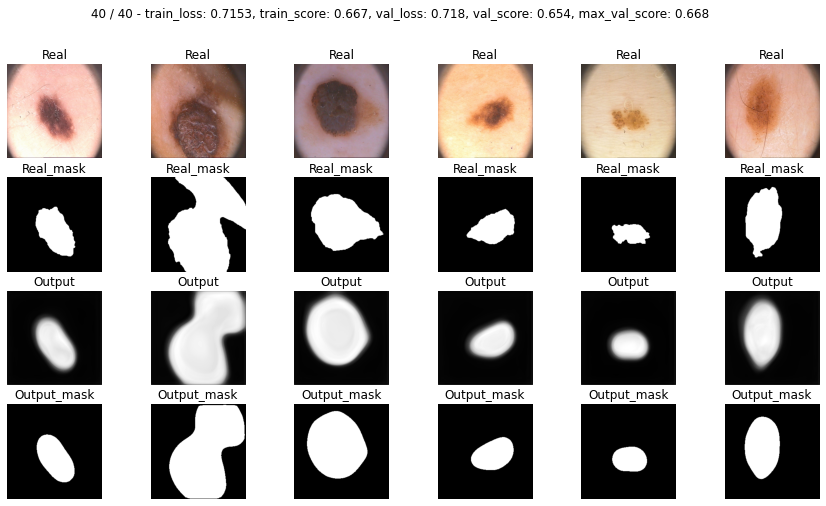

In [28]:
seed_init()
clear_memory()
model_bce = SegNet().to(device)


opt = optim.Adam(model_bce.parameters(), lr=lr)
history_bce = train('bce', model_bce, opt, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [29]:
score_model(model_bce, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6679999828338623

max score on train: 0.6670000404119492 with loss: 0.7152881622314453 
max score on val: 0.6680000126361847 with loss: 0.7214172184467316 


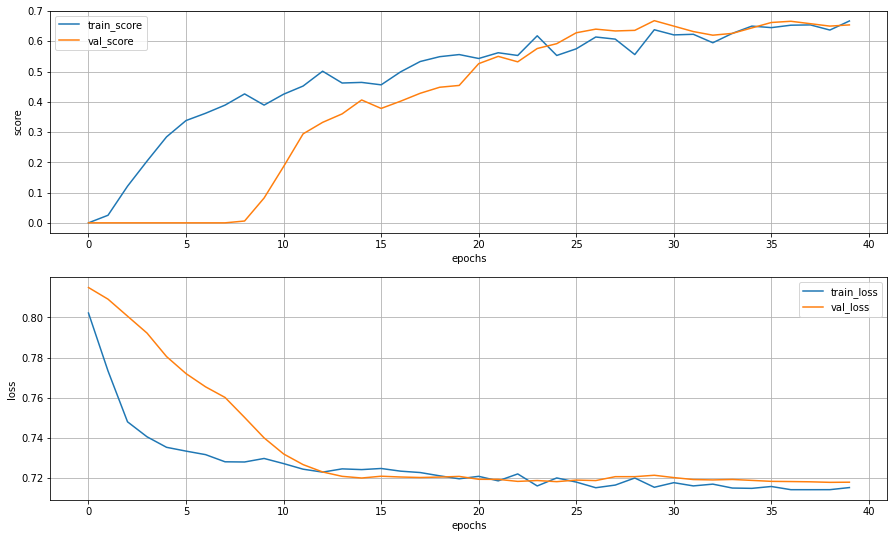

In [30]:
plot_stat(history_bce)

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_pred, y_real, eps=1e-8):
    y_pred, y_real = torch.sigmoid(y_pred.view(-1)), y_real.view(-1)
    num = 2. * y_pred * y_real
    den =  y_pred + y_real + eps
    res = torch.mean(num / den)
    return 1. - res 

Проводим тестирование:

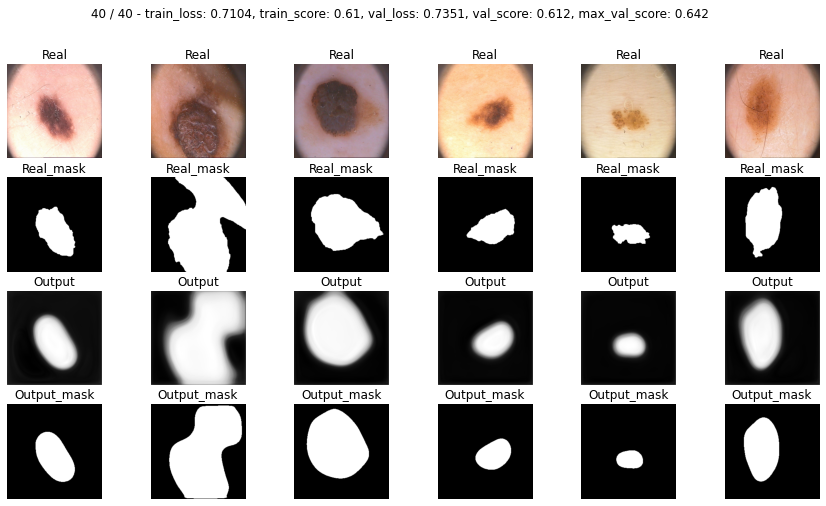

In [32]:
seed_init()
clear_memory()
model_dice = SegNet().to(device)

optimaiz = optim.Adam(model_dice.parameters(), lr=lr)
history_dice = train('dice', model_dice, optimaiz, dice_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [33]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6420000195503235

max score on train: 0.6449999958276749 with loss: 0.7093066871166229 
max score on val: 0.6420000195503235 with loss: 0.7307058572769165 


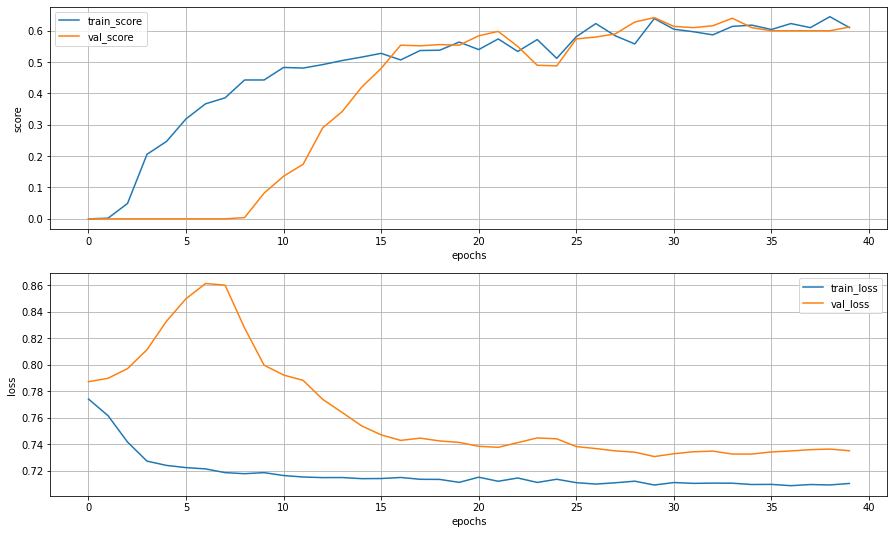

In [34]:
plot_stat(history_dice)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_pred, y_real, alpha=1, gamma=2, eps=1e-8, bce_loss=bce_loss):
    y_pred, y_real = y_pred.view(y_pred.shape[0], -1), y_real.view(y_pred.shape[0], -1)
    bce = bce_loss(y_pred, y_real, reduce=False) # F.binary_cross_entropy_with_logits(y_pred, y_real, reduce=False)
    pt = torch.exp( - bce)
    loss = alpha * ((1 - pt) ** gamma) * bce       
    # y_pred = hint: torch.clamp
    return loss.mean()

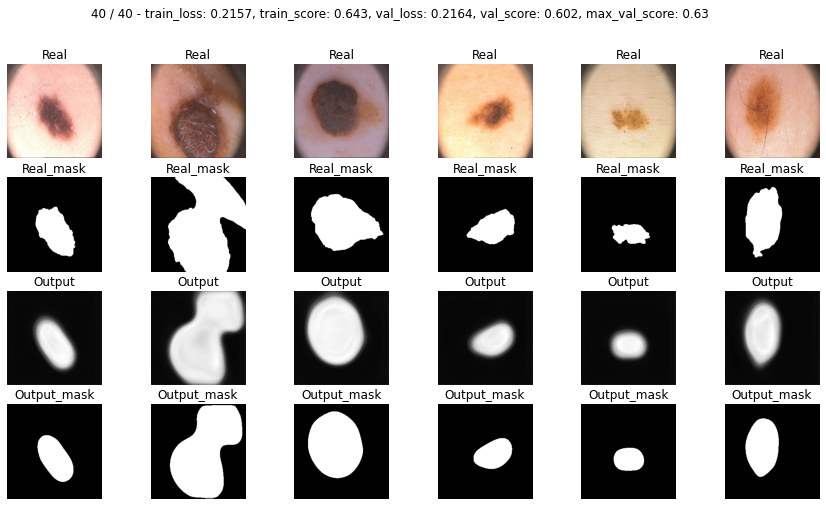

In [36]:
seed_init()
clear_memory()
model_focal = SegNet().to(device)

optimaiz = optim.Adam(model_focal.parameters(), lr=lr)
history_focal = train('focal', model_focal, optimaiz, focal_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [37]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6299999952316284

max score on train: 0.6470000147819519 with loss: 0.21528907120227814 
max score on val: 0.6300000250339508 with loss: 0.21781566739082336 


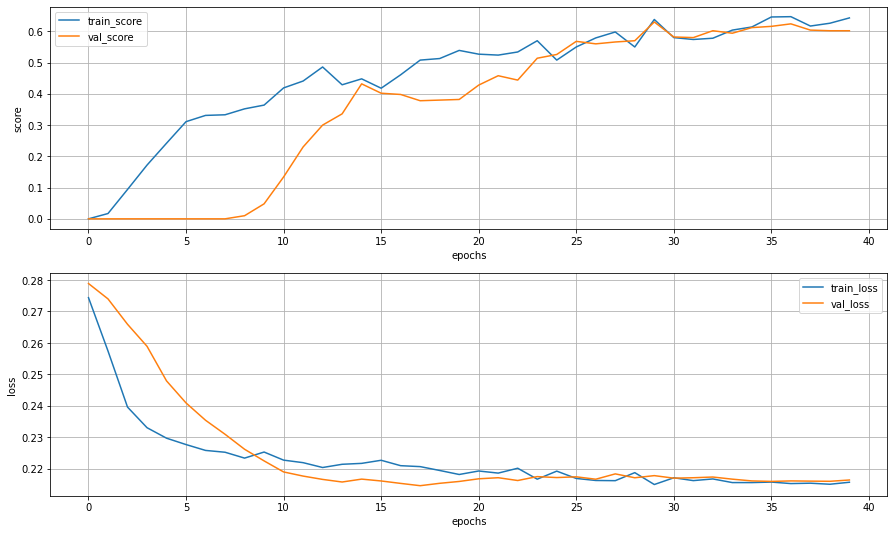

In [38]:
plot_stat(history_focal)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
#<TODO>
def tversky_loss(beta, eps = 1e-8):
    def loss(y_pred, y_real):
        y_pred, y_real = torch.sigmoid(y_pred.view(-1)), y_real.view(-1)
        numerator = torch.sum(y_real * y_pred)
        denominator = y_real * y_pred + beta * (1. - y_real) * y_pred + (1. - beta) * y_real * (1. - y_pred)
        return 1. - numerator / (torch.sum(denominator) + eps)
    return loss

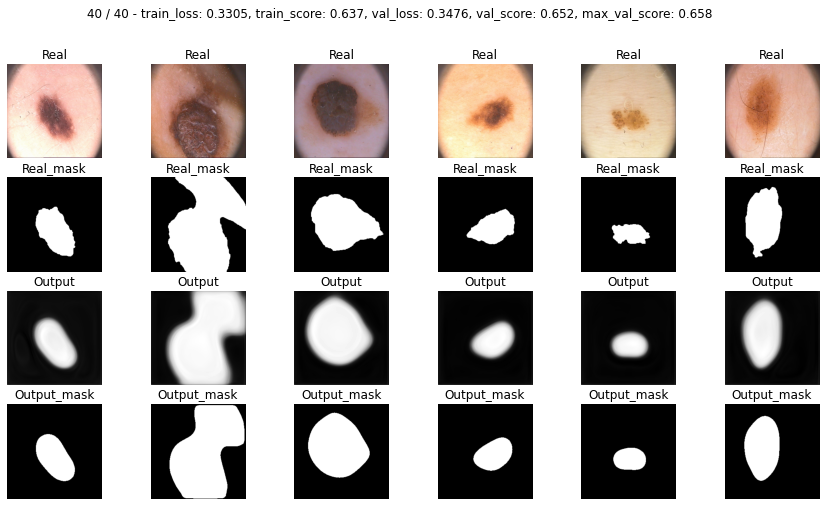

In [40]:
seed_init()
clear_memory()
model_tversky = SegNet().to(device)
tversky_loss_07 = tversky_loss(beta=.3) 

optima = optim.Adam(model_tversky.parameters(), lr=lr)
history_tversky = train('tversky', model_tversky, optima, tversky_loss_07, iou_pytorch, max_epochs, data_tr, data_val)

In [41]:
score_model(model_tversky, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6579999923706055

max score on train: 0.6500000059604645 with loss: 0.3270793706178665 
max score on val: 0.6579999923706055 with loss: 0.3447708189487457 


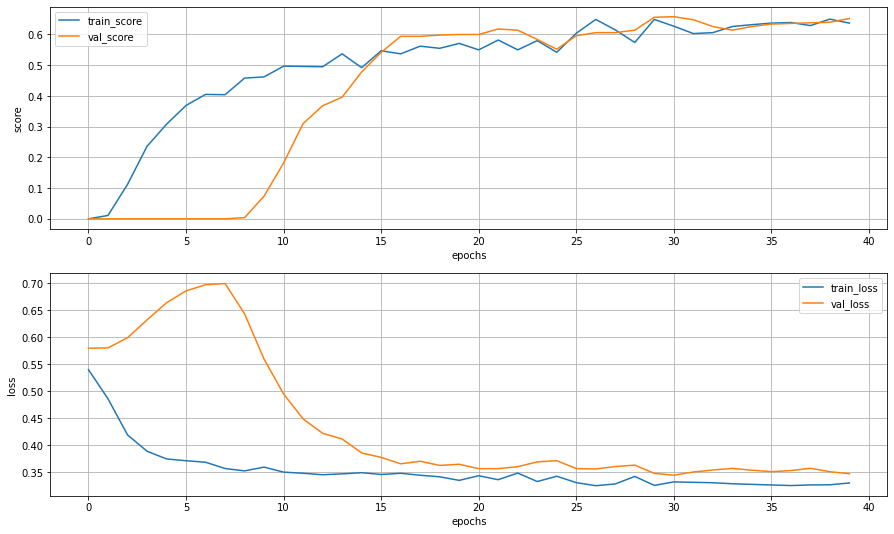

In [42]:
plot_stat(history_tversky)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

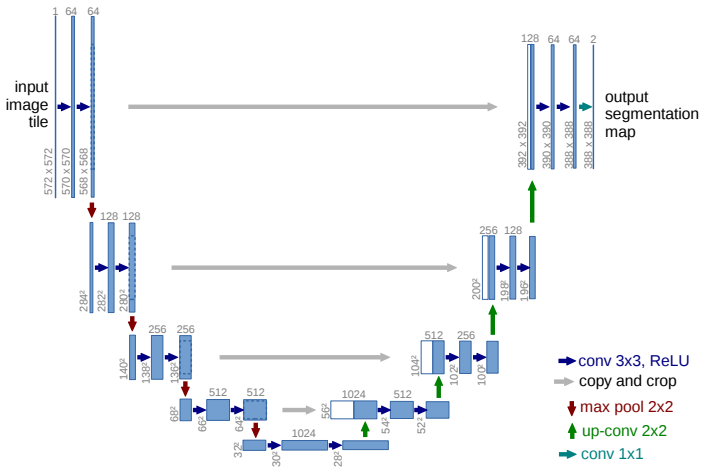

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            

        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            

        )
        
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode="bilinear") # 16 -> 32 
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample1 =  nn.Upsample(scale_factor=2, mode="bilinear") # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(256*2, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample2 =  nn.Upsample(scale_factor=2, mode="bilinear") # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(128*2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample3 =  nn.Upsample(scale_factor=2, mode="bilinear") # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(64*2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.dec_final = nn.Sequential(nn.Conv2d(32*2, 1, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(1)
                                       )            

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        # print('enc_part: ', self.enc_conv3(e2).shape,'+', 'dec_part: ', self.dec_conv0(self.upsample0(b)).shape) 
        d0 = torch.cat((self.enc_conv3(e2), self.dec_conv0(self.upsample0(b))), 1)
        # print('enc_part: ', self.enc_conv2(e1).shape,'+', 'dec_part: ', self.dec_conv1(self.upsample1(d0)).shape) 
        d1 = torch.cat((self.enc_conv2(e1), self.dec_conv1(self.upsample1(d0))), 1)
        # print('enc_part: ', self.enc_conv1(e0).shape,'+', 'dec_part: ', self.dec_conv2(self.upsample2(d1)).shape)  
        d2 = torch.cat((self.enc_conv1(e0), self.dec_conv2(self.upsample2(d1))), 1)
        # print('enc_part: ', self.enc_conv0(x).shape,'+', 'dec_part: ', self.dec_conv3(self.upsample3(d2)).shape) 
        d3 = torch.cat((self.enc_conv0(x), self.dec_conv3(self.upsample3(d2))), 1)
        # print(d3.shape)
        dfin = self.dec_final(d3)    # no activation
        # print(dfin.shape)
        return dfin

In [44]:
summary(UNet().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
seed_init()
clear_memory()

unet_model = UNet().to(device)
op = optim.Adam(unet_model.parameters(), lr=lr)

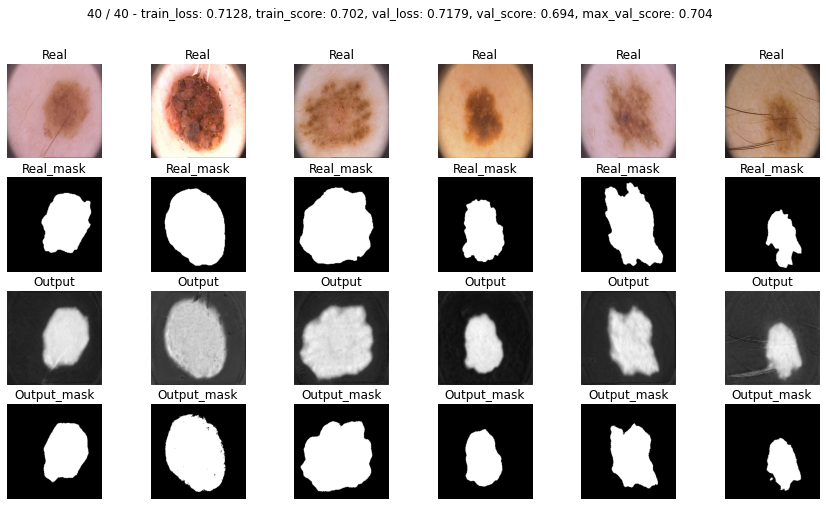

In [46]:
history_unet = train("unet", unet_model, op,  bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

max score on train: 0.7439999878406525 with loss: 0.7105973958969116 
max score on val: 0.7039999961853027 with loss: 0.7212292850017548 


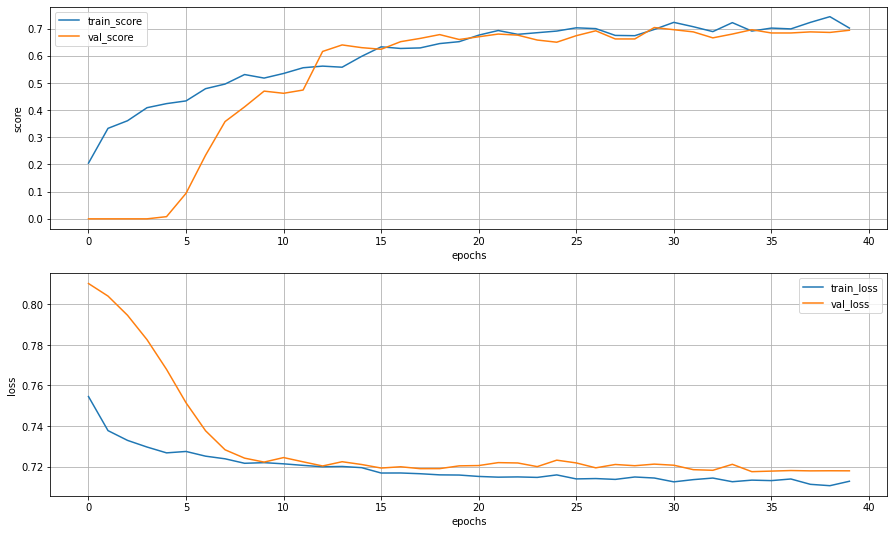

In [47]:
plot_stat(history_unet)

In [48]:
score_model(unet_model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7039999663829803

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self, near_neigh=True):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


        )

        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if near_neigh else nn.Conv2d(32, 32, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if near_neigh else nn.Conv2d(64, 64, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            

        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if near_neigh else nn.Conv2d(128, 128, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if near_neigh else nn.Conv2d(256, 256, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode='nearest') if near_neigh else nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2) # 16 -> 32 # torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample1 =  nn.Upsample(scale_factor=2, mode='nearest') if near_neigh else nn.ConvTranspose2d(256*2, 256*2, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(256*2, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample2 =  nn.Upsample(scale_factor=2, mode='nearest') if near_neigh else nn.ConvTranspose2d(128*2, 128*2, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(128*2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


        )
        # *2 - because concatenation
        self.upsample3 =  nn.Upsample(scale_factor=2, mode='nearest') if near_neigh else nn.ConvTranspose2d(64*2, 64*2, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(64*2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


        )
        # *2 - because concatenation
        self.dec_final = nn.Sequential(nn.Conv2d(32*2, 1, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(1)
                                       )            

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        # print('enc_part: ', self.enc_conv3(e2).shape,'+', 'dec_part: ', self.dec_conv0(self.upsample0(b)).shape) 
        d0 = torch.cat((self.enc_conv3(e2), self.dec_conv0(self.upsample0(b))), 1)
        # print('enc_part: ', self.enc_conv2(e1).shape,'+', 'dec_part: ', self.dec_conv1(self.upsample1(d0)).shape) 
        d1 = torch.cat((self.enc_conv2(e1), self.dec_conv1(self.upsample1(d0))), 1)
        # print('enc_part: ', self.enc_conv1(e0).shape,'+', 'dec_part: ', self.dec_conv2(self.upsample2(d1)).shape)  
        d2 = torch.cat((self.enc_conv1(e0), self.dec_conv2(self.upsample2(d1))), 1)
        # print('enc_part: ', self.enc_conv0(x).shape,'+', 'dec_part: ', self.dec_conv3(self.upsample3(d2)).shape) 
        d3 = torch.cat((self.enc_conv0(x), self.dec_conv3(self.upsample3(d2))), 1)
        # print(d3.shape)
        dfin = self.dec_final(d3)    # no activation
        # print(dfin.shape)
        return dfin

In [50]:
summary(UNet2().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

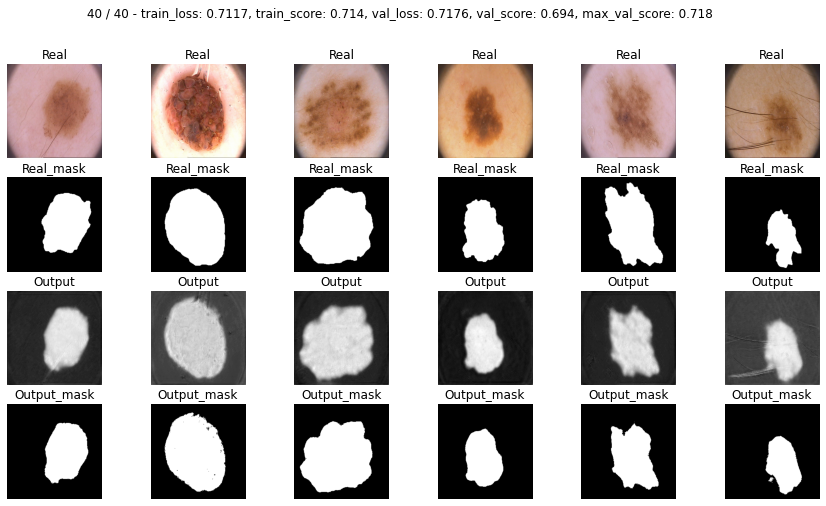

In [51]:
seed_init()
clear_memory()

unet2_1_model = UNet2().to(device)
op = optim.Adam(unet2_1_model.parameters(), lr=lr)
history_unet_2_1 = train('unet2_1', unet2_1_model, op, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [52]:
score_model(unet2_1_model, iou_pytorch, data_val)

0.7179999649524689

max score on train: 0.757999986410141 with loss: 0.7112099975347519 
max score on val: 0.7179999947547913 with loss: 0.720087319612503 


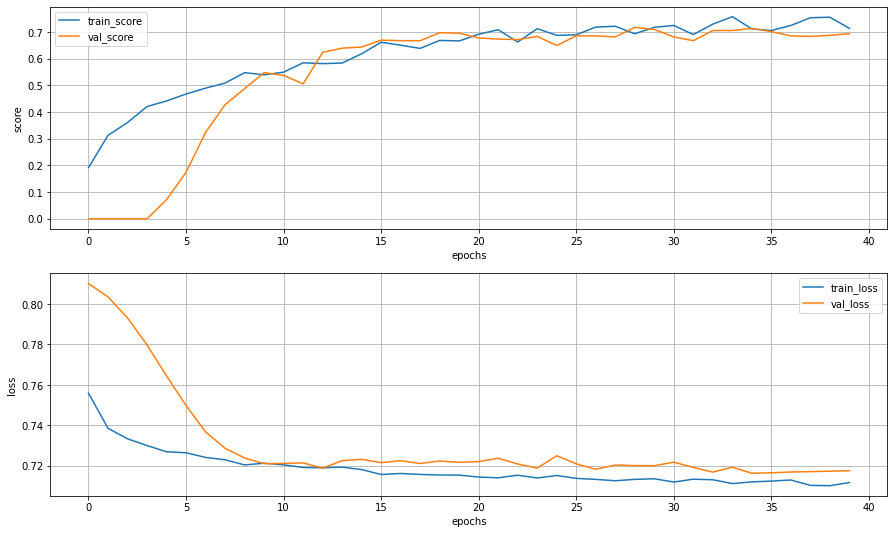

In [53]:
plot_stat(history_unet_2_1)

In [54]:
summary(UNet2(near_neigh=False).to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 128, 128]           4,128
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
           Conv2d-14           [-1, 64,

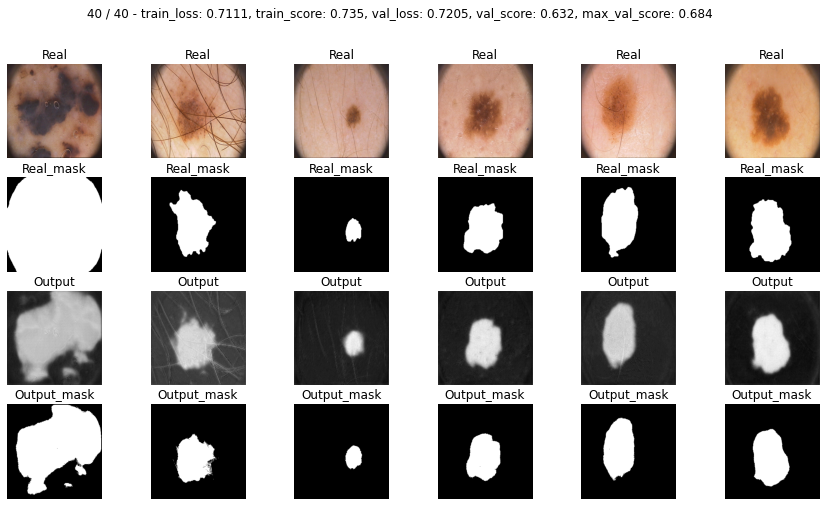

In [55]:
seed_init()
clear_memory()

unet2_2_model = UNet2(near_neigh=False).to(device)
opt = optim.Adam(unet2_2_model.parameters(), lr=lr)
history_unet_2_2 = train('unet2_2', unet2_2_model, opt, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

In [56]:
score_model(unet2_2_model, iou_pytorch, data_val)

0.6840000152587891

max score on train: 0.7409999668598175 with loss: 0.7117146849632263 
max score on val: 0.6840000152587891 with loss: 0.7189147472381592 


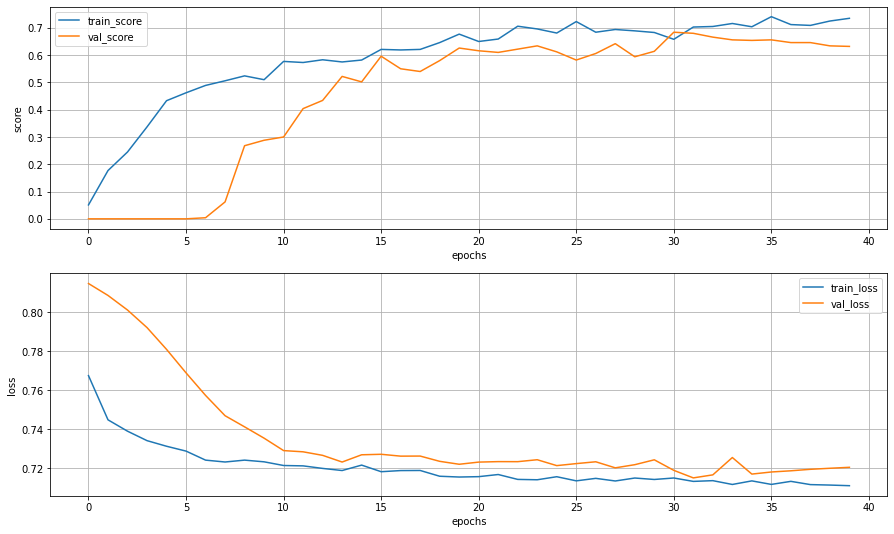

In [57]:
plot_stat(history_unet_2_2)

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


        )

        self.pool0 =  nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=1, dilation=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


        )
        self.pool1 = nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=1, dilation=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),


        )
        self.pool2 = nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=1, dilation=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.Conv2d(256, 256, kernel_size=2, stride=2, padding=1, dilation=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=1, output_padding=1, dilation=2) # 16 -> 32 # torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample1 = nn.ConvTranspose2d(256*2, 256*2, kernel_size=2, stride=2, padding=1, output_padding=1, dilation=2)  # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(256*2, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.upsample2 =  nn.ConvTranspose2d(128*2, 128*2, kernel_size=2, stride=2, padding=1, output_padding=1, dilation=2) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(128*2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


        )
        # *2 - because concatenation
        self.upsample3 = nn.ConvTranspose2d(64*2, 64*2, kernel_size=2, stride=2, padding=1, output_padding=1, dilation=2)  # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(64*2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

        )
        # *2 - because concatenation
        self.dec_final = nn.Sequential(nn.Conv2d(32*2, 1, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(1)
                                       )            

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        # print('enc_part: ', self.enc_conv3(e2).shape,'+', 'dec_part: ', self.dec_conv0(self.upsample0(b)).shape) 
        d0 = torch.cat((self.enc_conv3(e2), self.dec_conv0(self.upsample0(b))), 1)
        # print('enc_part: ', self.enc_conv2(e1).shape,'+', 'dec_part: ', self.dec_conv1(self.upsample1(d0)).shape) 
        d1 = torch.cat((self.enc_conv2(e1), self.dec_conv1(self.upsample1(d0))), 1)
        # print('enc_part: ', self.enc_conv1(e0).shape,'+', 'dec_part: ', self.dec_conv2(self.upsample2(d1)).shape)  
        d2 = torch.cat((self.enc_conv1(e0), self.dec_conv2(self.upsample2(d1))), 1)
        # print('enc_part: ', self.enc_conv0(x).shape,'+', 'dec_part: ', self.dec_conv3(self.upsample3(d2)).shape) 
        d3 = torch.cat((self.enc_conv0(x), self.dec_conv3(self.upsample3(d2))), 1)
        # print(d3.shape)
        dfin = self.dec_final(d3)    # no activation
        # print(dfin.shape)
        return dfin

In [59]:
summary(DilatedUNet().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 128, 128]           4,128
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
           Conv2d-14           [-1, 64,

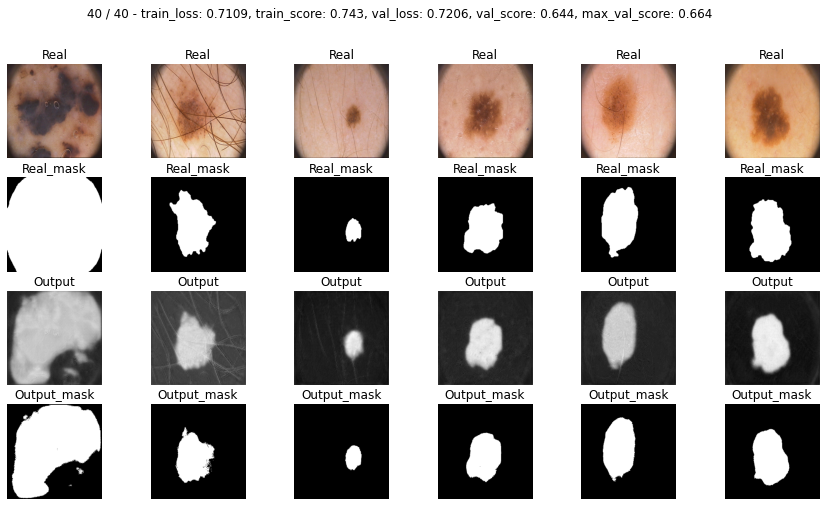

In [60]:
seed_init()
clear_memory()

unetdil_model = DilatedUNet().to(device)
opt = optim.Adam(unetdil_model.parameters(), lr=lr)
history_unetdil = train('unet_dil', unetdil_model, opt, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

max score on train: 0.7490000277757645 with loss: 0.7107290476560593 
max score on val: 0.6639999747276306 with loss: 0.7213621139526367 


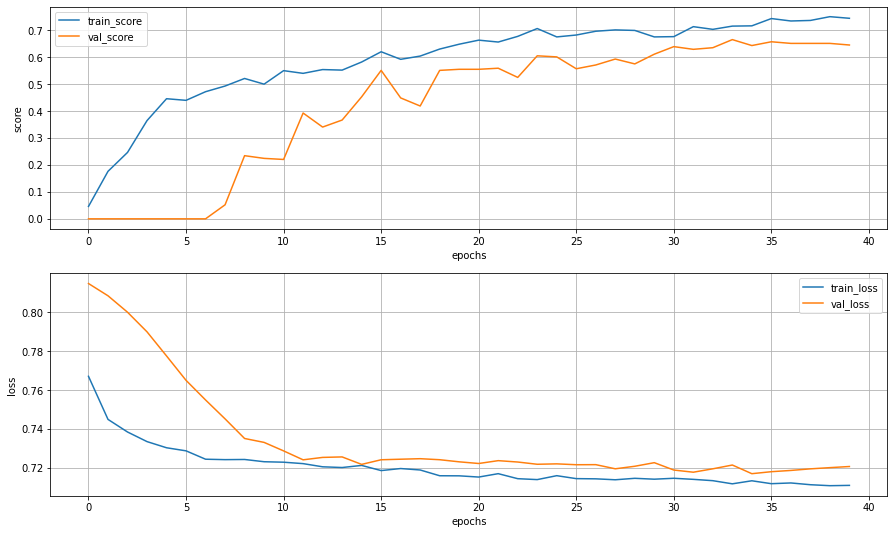

In [61]:
plot_stat(history_unetdil)

In [62]:
score_model(unetdil_model, iou_pytorch, data_val)

0.664000004529953

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



In [63]:
# Loss and Score on test

stat_on_test = dict()
losses_fn = [bce_loss, dice_loss, focal_loss, tversky_loss(beta=0.3), bce_loss, bce_loss, bce_loss, bce_loss]
names = ['bce', 'dice', 'focal', 'tversky', 'maxpool(2,2) & upsamp(bilin)', 'maxpool(3,2,1) & upsamp(nearest)', 'conv(2,2) & conv trans(2, 2)', 'dilation']
models = [model_bce, model_dice, model_focal, model_tversky, unet_model, unet2_1_model, unet2_2_model, unetdil_model]

for name, model, loss_fn in zip(names, models, losses_fn):
    stat_on_test[name] = dict(zip(['loss', 'score'], eval(model, data_ts, loss_fn, iou_pytorch, threshold=.7)))   

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



loss_fn bce: 
max score on train, eph = 39: 0.667 with loss: 0.7153
mean 5 last ephs score on train: 0.6512 with loss: 0.7148

max score on val, eph = 29: 0.668 with loss: 0.7214
mean 5 last ephs score on val: 0.658 with loss: 0.7181

score on test: 0.6618 with loss: 0.7338

loss_fn dice: 
max score on train, eph = 38: 0.645 with loss: 0.7093
mean 5 last ephs score on train: 0.6184 with loss: 0.7096

max score on val, eph = 29: 0.642 with loss: 0.7307
mean 5 last ephs score on val: 0.6024 with loss: 0.7353

score on test: 0.6061 with loss: 0.7365

loss_fn focal: 
max score on train, eph = 36: 0.647 with loss: 0.2153
mean 5 last ephs score on train: 0.6358 with loss: 0.2155

max score on val, eph = 29: 0.63 with loss: 0.2178
mean 5 last ephs score on val: 0.6096 with loss: 0.2161

score on test: 0.6655 with loss: 0.2242

loss_fn tversky: 
max score on train, eph = 38: 0.65 with loss: 0.3271
mean 5 last ephs score on train: 0.6384 with loss: 0.3274

max score on val, eph = 30: 0.658 wit

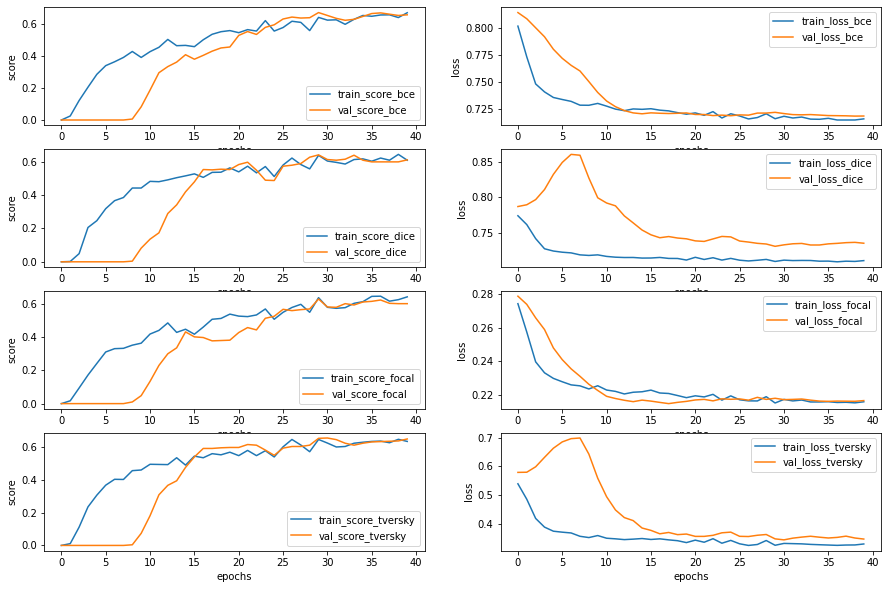

In [64]:
plt.figure(figsize=(15, 10))
i = 1
for name, history in zip(['bce', 'dice', 'focal', 'tversky'], [history_bce, history_dice, history_focal, history_tversky]):
    train_loss, train_score, val_loss, val_score = zip(*history)
    max_score_train = np.max(train_score)
    max_score_loss_train = train_loss[np.argmax(train_score)]
    max_score_val = np.max(val_score)
    max_score_loss_val = val_loss[np.argmax(val_score)]
    ts_score, ts_loss = stat_on_test[name]['score'], stat_on_test[name]['loss']

    print(f'\nloss_fn {name}: \nmax score on train, eph = {np.argmax(train_score)}: {np.round(max_score_train, 4)} with loss: {np.round(max_score_loss_train, 4)}')
    print(f'mean 5 last ephs score on train: {np.round(np.mean(train_score[max_epochs-5:]), 4)} with loss: {np.round(np.mean(train_loss[max_epochs-5:]), 4)}')
    print(f'\nmax score on val, eph = {np.argmax(val_score)}: {np.round(max_score_val, 4)} with loss: {np.round(max_score_loss_val, 4)}')
    print(f'mean 5 last ephs score on val: {np.round(np.mean(val_score[max_epochs-5:]), 4)} with loss: {np.round(np.mean(val_loss[max_epochs-5:]), 4)}')
    print(f'\nscore on test: {np.round(ts_score, 4)} with loss: {np.round(ts_loss, 4)}')
    print('='*100)
    

    plt.subplot(4, 2, i)
    plt.plot(train_score, label=f"train_score_{name}")
    plt.plot(val_score, label=f"val_score_{name}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("score")
    
    plt.subplot(4, 2, i+1)
    plt.plot(train_loss, label=f"train_loss_{name}")
    plt.plot(val_loss, label=f"val_loss_{name}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    i += 2
    
plt.show()


unet with maxpool(2,2) & upsamp(bilin): 
max score on train, eph = 38: 0.744 with loss: 0.7106
mean 5 last ephs score on train: 0.714 with loss: 0.7123

max score on val, eph = 29: 0.704 with loss: 0.7212
mean 5 last ephs score on val: 0.6872 with loss: 0.7179

score on test: 0.6872 with loss: 0.7301

unet with maxpool(3,2,1) & upsamp(nearest): 
max score on train, eph = 33: 0.758 with loss: 0.7112
mean 5 last ephs score on train: 0.731 with loss: 0.7115

max score on val, eph = 28: 0.718 with loss: 0.7201
mean 5 last ephs score on val: 0.6908 with loss: 0.7171

score on test: 0.6963 with loss: 0.7318

unet with conv(2,2) & conv trans(2, 2): 
max score on train, eph = 35: 0.741 with loss: 0.7117
mean 5 last ephs score on train: 0.7244 with loss: 0.7118

max score on val, eph = 30: 0.684 with loss: 0.7189
mean 5 last ephs score on val: 0.6428 with loss: 0.7193

score on test: 0.6963 with loss: 0.725

unet with dilation: 
max score on train, eph = 38: 0.749 with loss: 0.7107
mean 5 last

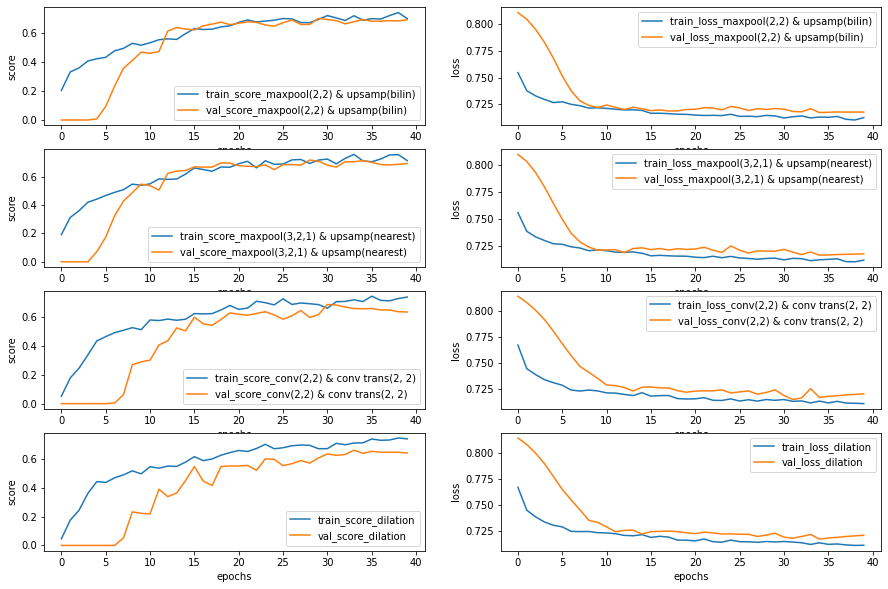

In [65]:
plt.figure(figsize=(15, 10))
i = 1
for name, history in zip(['maxpool(2,2) & upsamp(bilin)', 'maxpool(3,2,1) & upsamp(nearest)', 'conv(2,2) & conv trans(2, 2)', 'dilation'], [history_unet, history_unet_2_1, history_unet_2_2, history_unetdil]):
    train_loss, train_score, val_loss, val_score = zip(*history)
    max_score_train = np.max(train_score)
    max_score_loss_train = train_loss[np.argmax(train_score)]
    max_score_val = np.max(val_score)
    max_score_loss_val = val_loss[np.argmax(val_score)]
    ts_score, ts_loss = stat_on_test[name]['score'], stat_on_test[name]['loss']

    print(f'\nunet with {name}: \nmax score on train, eph = {np.argmax(train_score)}: {np.round(max_score_train, 4)} with loss: {np.round(max_score_loss_train, 4)}')
    print(f'mean 5 last ephs score on train: {np.round(np.mean(train_score[max_epochs-5:]), 4)} with loss: {np.round(np.mean(train_loss[max_epochs-5:]), 4)}') 
    print(f'\nmax score on val, eph = {np.argmax(val_score)}: {np.round(max_score_val, 4)} with loss: {np.round(max_score_loss_val, 4)}')
    print(f'mean 5 last ephs score on val: {np.round(np.mean(val_score[max_epochs-5:]), 4)} with loss: {np.round(np.mean(val_loss[max_epochs-5:]), 4)}')
    print(f'\nscore on test: {np.round(ts_score, 4)} with loss: {np.round(ts_loss, 4)}')
    print('='*100)

    plt.subplot(4, 2, i)
    plt.plot(train_score, label=f"train_score_{name}")
    plt.plot(val_score, label=f"val_score_{name}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("score")
    
    plt.subplot(4, 2, i+1)
    plt.plot(train_loss, label=f"train_loss_{name}")
    plt.plot(val_loss, label=f"val_loss_{name}")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    i+=2
    
plt.show()

## Выводы

### Segnet with different Losses

|        | BCE loss  | dice loss | focal loss | tversky loss (beta=0.7) |                 
| ------ | ------ | ------ | ------ | ------ | 
| max val score | 0.668 | 0.642 | 0.63 | 0.658  |
| mean 5 last ephs val score | 0.658 | 0.6024 | 0.6908 | 0.64|
| test score | 0.6618 | 0.6061 | 0.6655 | 0.653 |







В таблице приведена метрика IoU на валидации при обучении, а также  на тесте после обучения:
<br>model = *SegNet*
<br>optimaizer = *Adam*
<br>lr = *1e-4*
<br>scheduler = *gamma = 0.1*, *step_size = 35*
<br>epochs = *40*
<br><br>***Заключения по таблице:***
<br>Лучший результат наблюдается при использовании целевой функции **focal loss**:
<br>

|        | focal loss |                 
| ------ |  ------ | 
| max val score |  0.63  |
| mean 5 last ephs val score |  0.6908 |
| test score |  0.6655 |

### Unet with Downsampling & Upsampling

|                            |                             downsample & upsampling                             |                                  downsample & upsampling                                 |                                        downsample & upsampling                                        |                                                            Dilated convolutions<br>downsample & upsampling                                                            |
|:--------------------------:|:-------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------:|:-----------------------------------------------------------------------------------------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Unet with                  | MaxPool2d(kernel_size = 2, stride = 2)<br>Upsample(scale_factor = 2, mode = "bilinear") | MaxPool2d(kernel_size = 3, stride = 2, padding = 1)<br>Upsample(scale_factor = 2, mode = 'nearest') | Conv2d(input, output, kernel_size = 2, stride = 2)<br>ConvTranspose2d(input, output, kernel_size = 2, stride = 2 ) | Conv2d(input, output, kernel_size = 2, stride = 2, padding = 1, dilation = 2)<br>ConvTranspose2d(input, output, kernel_size = 2, stride = 2, padding = 1, output_padding = 1, dilation = 2) |
| max val score              | 0.704                                                                           | 0.718                                                                                    | 0.684                                                                                                 | 0.664                                                                                                                                                                 |
| mean 5 last ephs val score | 0.6872                                                                          | 0.6908                                                                                     | 0.6428                                                                                                | 0.65                                                                                                                                                                |
| test score                 | 0.6872                                                                           | 0.6963                                                                                    | 0.6963                                                                                                 | 0.6968                                                                                                                                                                 |

В таблице приведена метрика IoU на валидации при обучении, а также  на тесте после обучения:
<br>model = *Unet*
<br>optimaizer = *Adam*
<br>scheduler = *gamma = 0.1*, *step_size = 35*
<br>lr = *1e-4*
<br>epochs = *40*
<br><br>***Заключения по таблице:***
<br>Лучший результат наблюдается при использовании в качестве <br> Downsampling - *Conv2d(input, output, kernel_size = 2, stride = 2, padding = 1, dilation = 2)*, <br>Upsampling - *ConvTranspose2d(input, output, kernel_size = 2, stride = 2, padding = 1, output_padding = 1, dilation = 2)*:
<br>

|                            |                             Dilated convolutions<br>downsample & upsampling                             |
|:--------------------------:|:-------------------------------------------------------------------------------:|
| Unet with                  | Conv2d(input, output, kernel_size = 2, stride = 2, padding = 1, dilation = 2)<br>ConvTranspose2d(input, output, kernel_size = 2, stride = 2, padding = 1, output_padding = 1, dilation = 2) |
| max val score              | 0.664                                                                           |
| mean 5 last ephs val score | 0.65                                                                          |
| test score                 | 0.6968                                                                           |

<br>
Результаты на тесте имеет наивысший приоритет:
<br>
test score = 0.6968


### Наилучшая архитектура

Unet with Dilated convolutions
<br> Downsampling - *Conv2d(input, output, kernel_size = 2, stride = 2, padding = 1, dilation = 2)*, 
<br>Upsampling - *ConvTranspose2d(input, output, kernel_size = 2, stride = 2, padding = 1, output_padding = 1, dilation = 2)*
<br>Loss - *focal loss*

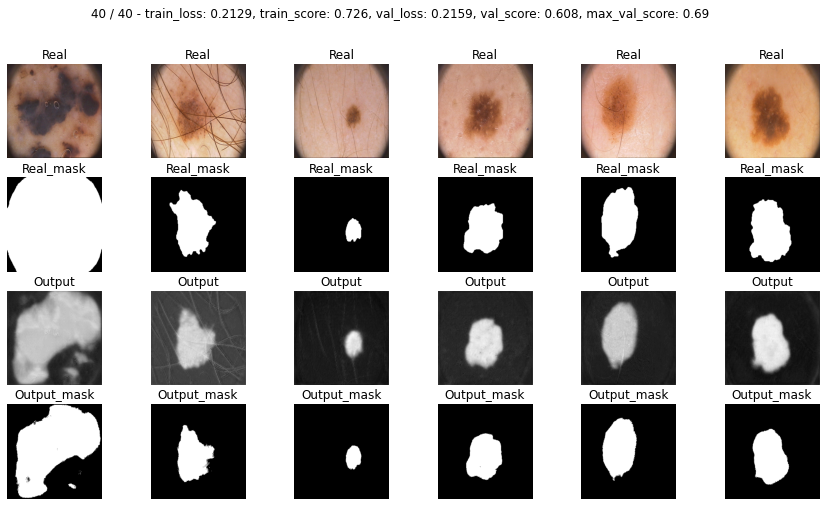

In [66]:
seed_init()
clear_memory()

model_final = DilatedUNet().to(device)
op = optim.Adam(model_final.parameters(), lr=lr)
history_final = train('final', model_final, op, focal_loss, iou_pytorch, max_epochs, data_tr, data_val)

max score on train: 0.7260000109672546 with loss: 0.21290815249085426 
max score on val: 0.6899999976158142 with loss: 0.2169673666357994 


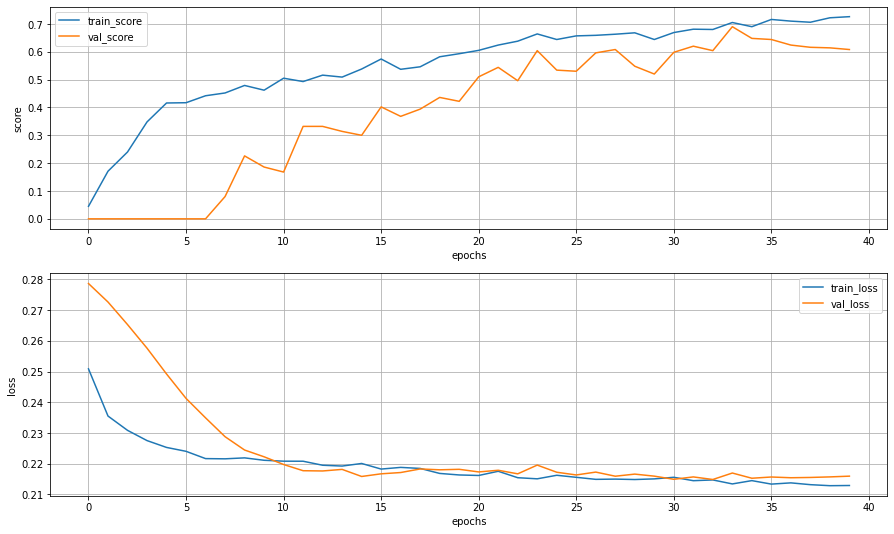

In [67]:
plot_stat(history_final)

In [70]:
print('the best score on val: ')
score_model(model_final, iou_pytorch, data_val)

the best score on val: 


0.6899999678134918

In [69]:
train_loss_final, train_score_final, val_loss_final, val_score_final = zip(*history_final)
model_final_ts_score, model_final_ts_loss = eval(model_final, data_ts, bce_loss, iou_pytorch, threshold=.8)

print(f'\nfinalmodel: \nmax score on train, eph = {np.argmax(train_score)}: {np.round(np.max(train_score_final), 4)} with loss: {np.round(train_loss_final[np.argmax(train_score_final)], 4)}')
print(f'mean 5 last ephs score on train: {np.round(np.mean(train_score_final[max_epochs-5:]), 4)} with loss: {np.round(np.mean(train_loss_final[max_epochs-5:]), 4)}') 
print(f'\nmax score on val, eph = {np.argmax(val_score)}: {np.round(np.max(val_score_final), 4)} with loss: {np.round(val_loss_final[np.argmax(val_score_final)], 4)}')
print(f'mean 5 last ephs score on val: {np.round(np.mean(val_score_final[max_epochs-5:]), 4)} with loss: {np.round(np.mean(val_loss_final[max_epochs-5:]), 4)}')
print(f'\ntest score: {model_final_ts_score}, test loss: {model_final_ts_loss}')


finalmodel: 
max score on train, eph = 38: 0.726 with loss: 0.2129
mean 5 last ephs score on train: 0.716 with loss: 0.2132

max score on val, eph = 33: 0.69 with loss: 0.217
mean 5 last ephs score on val: 0.6212 with loss: 0.2157

test score: 0.7242080569267273, test loss: 0.5523333251476288


Такая архитектура даёт test score = 0.7242